In [21]:
pip install shap

In [22]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
import shap

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/Fibovin/des_modelos_1/refs/heads/main/Student_Performance.csv')
df.head(5)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [24]:
#Paso 1
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0}) #Codificamos la variable Extracurricular Activities ya que es categorica

## **Split de los datos**

In [25]:
#Separamos las variables preiotras de la variable objetivo
X = df.drop(columns=["Performance Index"])
y = df["Performance Index"]

## **Entrenamiento del modelo - Regresión SVR**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Dividimos los datos en un 80-20

#Creamos el modelo SVR con kernel lineal
svr_model = SVR(kernel="linear")
svr_model.fit(X_train, y_train)

#Realizamos las predicciones en el conjunto de prueba
y_train_pred_svr = svr_model.predict(X_train)
y_test_pred_svr = svr_model.predict(X_test)

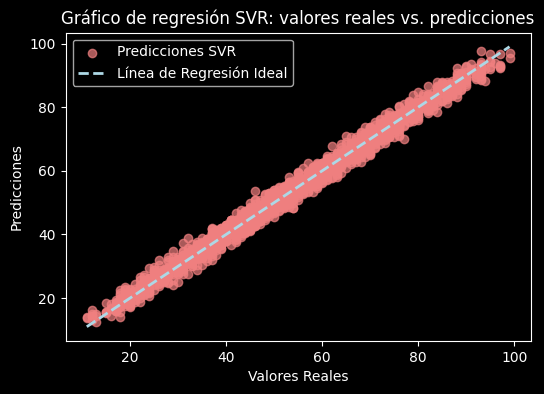

In [27]:
#Graficamos la regresion de SVR
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred_svr, color="lightcoral", label="Predicciones SVR", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="lightblue", linestyle="--", lw=2, label="Línea de Regresión Ideal")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Gráfico de regresión SVR: valores reales vs. predicciones")
plt.legend()
plt.show()

## **Evaluación del modelo - Regresión SVR**

In [28]:
#Calculamos las métricas para el conjunto de entrenamiento
svr_r2_train = svr_model.score(X_train, y_train)
svr_mse_train = mean_squared_error(y_train, y_train_pred_svr)
svr_mae_train = mean_absolute_error(y_train, y_train_pred_svr)

#Calculamos las métricas para el conjunto de prueba
svr_r2_test = svr_model.score(X_test, y_test)
svr_mse_test = mean_squared_error(y_test, y_test_pred_svr)
svr_mae_test = mean_absolute_error(y_test, y_test_pred_svr)

#Resultados integrados
svr_summary = [["Entrenamiento", svr_r2_train, svr_mse_train, svr_mae_train],["Prueba", svr_r2_test, svr_mse_test, svr_mae_test]]
print(tabulate(svr_summary, headers=["Conjunto", "R²", "MSE", "MAE"], tablefmt="fancy_grid", floatfmt="g"))

╒═══════════════╤══════════╤═════════╤═════════╕
│ Conjunto      │       R² │     MSE │     MAE │
╞═══════════════╪══════════╪═════════╪═════════╡
│ Entrenamiento │ 0.988686 │ 4.17108 │ 1.61901 │
├───────────────┼──────────┼─────────┼─────────┤
│ Prueba        │ 0.988978 │ 4.0846  │ 1.61176 │
╘═══════════════╧══════════╧═════════╧═════════╛


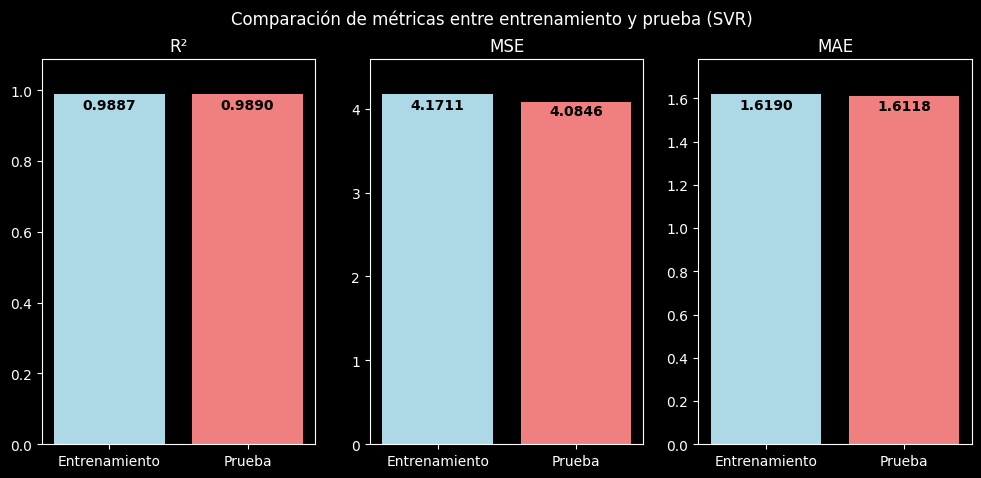

In [29]:
metric_names = ["R²", "MSE", "MAE"]
train_metrics = [svr_r2_train, svr_mse_train, svr_mae_train]
test_metrics = [svr_r2_test, svr_mse_test, svr_mae_test]

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i, metric in enumerate(metric_names):
    bars = ax[i].bar(["Entrenamiento", "Prueba"], [train_metrics[i], test_metrics[i]], color=['lightblue', 'lightcoral'])
    ax[i].set_title(metric)
    ax[i].set_ylim(0, max(train_metrics[i], test_metrics[i]) * 1.1)

    for bar, value in zip(bars, [train_metrics[i], test_metrics[i]]):
        ax[i].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - (bar.get_height() * 0.05),
            f"{value:.4f}",
            ha="center",
            va="bottom",
            color="black",
            fontweight="bold"
        )

plt.suptitle("Comparación de métricas entre entrenamiento y prueba (SVR)")
plt.show()

**Análisis**

Los resultados muestran un R² alto y muy similar tanto en el conjunto de entrenamiento (0.9887) como en el de prueba (0.9890), por lo tanto el modelo generaliza bien y no presenta sobreajuste. Los valores de MSE y MAE son también consistentes entre los dos conjuntos, con ligeras diferencias, lo cual refuerza la estabilidad del modelo. Estos resultados sugieren que el modelo SVR está capturando bien la relación en los datos y tiene un rendimiento confiable en ambos conjuntos.

## **Análisis de importancia de variables- Regresión SVR**

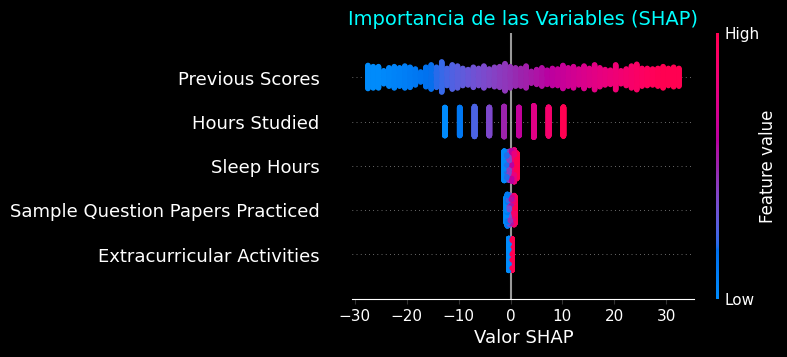

In [30]:
#Creamos el SHAP para la regresión SVR
explainer = shap.Explainer(svr_model, X_train)
shap_values = explainer(X_test)
plt.style.use("dark_background")
plt.figure(figsize=(10, 3))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("Importancia de las Variables (SHAP)", color="cyan", fontsize=14)
plt.xlabel("Valor SHAP", color="white")
plt.xticks(color="white")
plt.yticks(color="white")
plt.show()

In [31]:
# Ordenar las variables por importancia
importance_df = pd.DataFrame({"Variable": X_test.columns,"Importancia Promedio": np.abs(shap_values.values).mean(axis=0)})
importance_df = importance_df.sort_values(by="Importancia Promedio", ascending=True)
table = tabulate(importance_df, headers="keys", tablefmt="fancy_grid", showindex=False)
print(table)

╒══════════════════════════════════╤════════════════════════╕
│ Variable                         │   Importancia Promedio │
╞══════════════════════════════════╪════════════════════════╡
│ Extracurricular Activities       │               0.32576  │
├──────────────────────────────────┼────────────────────────┤
│ Sample Question Papers Practiced │               0.466851 │
├──────────────────────────────────┼────────────────────────┤
│ Sleep Hours                      │               0.706344 │
├──────────────────────────────────┼────────────────────────┤
│ Hours Studied                    │               6.42541  │
├──────────────────────────────────┼────────────────────────┤
│ Previous Scores                  │              15.3043   │
╘══════════════════════════════════╧════════════════════════╛


**Análisis**

El análisis de la importancia promedio en el modelo SVR muestra que Previous Scores es la variable más relevante, seguida por Hours Studied, por lo tanto el rendimiento previo y las horas de estudio tienen el mayor impacto en las predicciones del modelo. En cambio, variables como Sleep Hours, Sample Question Papers Practiced y Extracurricular Activities tienen una influencia mucho menor, por lo tanto su efecto sobre el rendimiento predicho es mínimo en comparación con las dos variables principales.

## **Tunning del modelo - Regresión SVR**

### **Métodos de Ensamble**

In [32]:
#Raalizamos el ensamble al modelo
svr = SVR(C=1.0, kernel='rbf')
lr = LinearRegression()

ensemble_model = VotingRegressor([('svr', svr), ('lr', lr)])
ensemble_model.fit(X_train, y_train)

VotingRegressor(estimators=[('svr', SVR()), ('lr', LinearRegression())])

In [34]:
# Realizar predicciones con el metodo de ensamble
y_test_pred_ensemble = ensemble_model.predict(X_test)

#Calculamos las métricas
r2_ensemble = r2_score(y_test, y_test_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_test_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test, y_test_pred_ensemble)

ensemble_results = [["R²", r2_ensemble],["MSE", mse_ensemble],["MAE", mae_ensemble]]
print(tabulate(ensemble_results, headers=["Métrica", "Valor"], tablefmt="fancy_grid", floatfmt="g"))

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ R²        │ 0.988048 │
├───────────┼──────────┤
│ MSE       │ 4.42919  │
├───────────┼──────────┤
│ MAE       │ 1.67059  │
╘═══════════╧══════════╛


## **Comparación de los modelos- Regresión SVR**

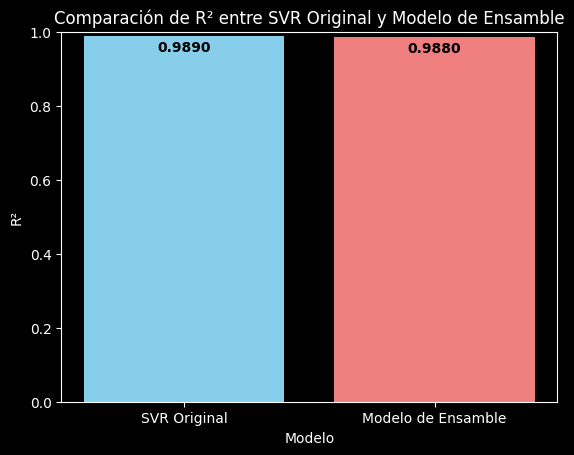

In [35]:
model_names = ["SVR Original", "Modelo de Ensamble"]
r2_values = [svr_r2_test, r2_ensemble]
bars = plt.bar(model_names, r2_values, color=["skyblue", "lightcoral"])
plt.xlabel("Modelo")
plt.ylabel("R²")
plt.title("Comparación de R² entre SVR Original y Modelo de Ensamble")
plt.ylim(0, 1)

for bar, r2_value in zip(bars, r2_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 0.05,
        f"{r2_value:.4f}",
        ha="center",
        va="bottom",
        color="black",
        fontweight="bold"
    )

plt.show()

**Conclusión**

Ambos modelos presentan un rendimiento muy similar, con un R² de 0.9890 para el SVR original y 0.9880 para el modelo de ensamble. La diferencia es mínima, el modelo de ensamble no mejora significativamente el rendimiento en comparación con el modelo SVR original.

Por lo tanto el modelo SVR por sí solo ya está capturando bien la variabilidad en los datos, y añadir el modelo de regresión lineal en el ensamble no aporta un beneficio notable en términos de precisión. Esto podría deberse a que el SVR ya está optimizado y el ensamble no introduce la suficiente diversidad en la predicción para mejorar el ajuste.